In [350]:
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Read blackbox call history

In [351]:
column_names = list()
data = list()
is_first_row = True
with open('slhc_test.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if is_first_row:
            for x in row:
                column_names.append(x)
            is_first_row = False
        else:
            data.append([float(x) for x in row])
data = np.array(data)

sur_data = data[-100:, :]
_X = sur_data[:, :6]
_y = sur_data[:, 6]

# Artificial blackbox creation
We have establishedthe Gradiant boost as the best aproximating model and now were are choosing the best parameters for our model.

In [352]:
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [353]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [354]:
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.2, random_state=42)

kfold = KFold(n_splits=10, shuffle=True)

In [355]:
def model_performance(model, metrics, X=X_test, y=y_test):
    """
    Get accuracy score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    res = 0 
    if metrics == 'neg_mean_absolute_error':
        res = -mean_absolute_error(y_pred, y)
    if metrics == 'neg_mean_squared_error':
        res = -mean_squared_error(y_pred, y)
    if metrics == 'r2':
        res = r2_score(y_pred, y)
    return res

In [356]:
from sklearn import gaussian_process
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [357]:
def create_model(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    lr = trial.suggest_uniform('learning_rate', 0.01, 0.9) 
    loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    model = GradientBoostingRegressor(n_estimators = n_estimators, max_depth=max_depth, learning_rate = lr, loss=loss)
    
    if trial.should_prune():
            raise optuna.TrialPruned()
            
    return model


def objective(trial, metrics):
    model = create_model(trial)
    model.fit(X_train, y_train)
    return model_performance(model, metrics)
    #return (cross_val_score(model, X, y, cv=kfold, scoring=metrics)).mean()

In [358]:
study = optuna.create_study(direction='maximize', study_name="starter-experiment")
metrics_ =  'r2'#'neg_mean_absolute_error', 'r2' , 'neg_mean_squared_error'
study.optimize(lambda trial: objective(trial, metrics_), n_trials=20)
model_fix = create_model(study.best_trial)
model_fix.fit(X_train, y_train)
print("Performance: ", model_performance(model_fix, metrics_))
print(study.best_params)

[I 2023-04-10 21:53:08,933] A new study created in memory with name: starter-experiment
<ipython-input-357-4f11655eb95f>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-04-10 21:53:09,234] Trial 0 finished with value: -7.677476732907598 and parameters: {'n_estimators': 167, 'max_depth': 1, 'learning_rate': 0.05425173827456395, 'loss': 'absolute_error'}. Best is trial 0 with value: -7.677476732907598.
<ipython-input-357-4f11655eb95f>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-04-10 21:53:10,757] Trial 1 finished with value: -0.3354118852811834 and parameters: {'n_estimators': 137, 'max_depth': 14, 'learning_rate': 0.223589534303

<ipython-input-357-4f11655eb95f>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-04-10 21:53:42,225] Trial 16 finished with value: 0.0811961554978834 and parameters: {'n_estimators': 627, 'max_depth': 10, 'learning_rate': 0.5466745346713722, 'loss': 'absolute_error'}. Best is trial 15 with value: 0.39189271374758516.
<ipython-input-357-4f11655eb95f>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2023-04-10 21:53:47,379] Trial 17 finished with value: -0.2241822988859572 and parameters: {'n_estimators': 970, 'max_depth': 6, 'learning_rate': 0.5262840429402872, 'loss': 'absolute_error'}. Best is trial 15 with value: 0.39189271374758516.
<i

Performance:  0.2796174698124012
{'n_estimators': 905, 'max_depth': 10, 'learning_rate': 0.5664649324549511, 'loss': 'absolute_error'}


In [359]:
fig = optuna.visualization.plot_edf(study)
fig.show()

# Different acqf
## Random, generating new configurations

In [360]:
from sklearn import gaussian_process
import random
import noise

#help(noise)

def noise_strategy(y, strategy):
    if strategy == 'gauss':
        return random.gauss(0, 0.02*y)
    if strategy == 'perlin':
        return pnoise1(0.02*y)
    return 0

In [361]:
def objective1(trial, model, strategy):
    #lb = np.array([3, 850, 850, 53, 1700000, 136])
    #ub = np.array([5, 1150, 1150, 73, 2300000, 184])
    NUM_THREADS = trial.suggest_int("NUM_THREADS", 3, 5)
    DEFAULT_TICKS_PER_SLOT = trial.suggest_int("DEFAULT_TICKS_PER_SLOT",
                                                 850, 1150)
    ITER_BATCH_SIZE = trial.suggest_int("ITER_BATCH_SIZE",
                                                 850, 1150)
    RECV_BATCH_MAX_CPU = trial.suggest_int("RECV_BATCH_MAX_CPU",
                                                 53, 73)
    DEFAULT_HASHES_PER_SECOND = trial.suggest_int("DEFAULT_HASHES_PER_SECOND",
                                                 1700000, 2300000)
    DEFAULT_TICKS_PER_SECOND = trial.suggest_int("DEFAULT_TICKS_PER_SECOND",
                                                 136, 184)
    X = [[NUM_THREADS,DEFAULT_TICKS_PER_SLOT,ITER_BATCH_SIZE,RECV_BATCH_MAX_CPU,DEFAULT_HASHES_PER_SECOND,DEFAULT_TICKS_PER_SECOND]]
    y = model.predict(X) #here we can call the artificial blackbox
    return y + noise_strategy(y, strategy) #adding noise


def get_points(name_of_file, model, Num_of_points, strategy):
    header = ['NUM_THREADS','DEFAULT_TICKS_PER_SLOT','ITER_BATCH_SIZE','RECV_BATCH_MAX_CPU',
              'DEFAULT_HASHES_PER_SECOND','DEFAULT_TICKS_PER_SECOND', 'AVERAGE_TPS']
    with open(name_of_file, 'w', encoding='UTF8', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(model.get_params())
        writer.writerow(pd.get_dummies(model.get_params()))
        #print(model.get_params())
        writer.writerow(header)
        
        for i in range(Num_of_points):
            study1 = optuna.create_study(direction='maximize', study_name="opt-experiment")
            study1.optimize(lambda trial: objective1(trial, model, strategy), n_trials=10)

            best_trial = study1.best_trial
            
            my_dict = best_trial.params
            #print(my_dict.type())
        
            AVERAGE_TPS_i = best_trial.value
            my_data_ordered = [my_dict['NUM_THREADS'],my_dict['DEFAULT_TICKS_PER_SLOT'],my_dict['ITER_BATCH_SIZE'],my_dict['RECV_BATCH_MAX_CPU'],
            my_dict['DEFAULT_HASHES_PER_SECOND'],my_dict['DEFAULT_TICKS_PER_SECOND'], AVERAGE_TPS_i]
            my_data_ordered = [float(i) for i in my_data_ordered]
            #print(AVERAGE_TPS_i)
            #print(pd.get_dummies(my_dict))
            writer.writerow(my_data_ordered)
            
            #print("Best value GB: ", best_trial.value)
            #print("Parameters that achieve the best value: ", best_trial.params)
            #print("Acquisition function : ")
        

In [362]:
num_points = 20
strategy = ''
name_of_file = 'sur_model2_results.csv'
get_points(name_of_file, model_fix, num_points, strategy)

[I 2023-04-10 21:53:57,573] A new study created in memory with name: opt-experiment
[I 2023-04-10 21:53:57,580] Trial 0 finished with value: 26.546748381612023 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 1031, 'ITER_BATCH_SIZE': 1096, 'RECV_BATCH_MAX_CPU': 72, 'DEFAULT_HASHES_PER_SECOND': 2069634, 'DEFAULT_TICKS_PER_SECOND': 165}. Best is trial 0 with value: 26.546748381612023.
[I 2023-04-10 21:53:57,587] Trial 1 finished with value: 23.066766128002563 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 962, 'ITER_BATCH_SIZE': 1051, 'RECV_BATCH_MAX_CPU': 66, 'DEFAULT_HASHES_PER_SECOND': 2180328, 'DEFAULT_TICKS_PER_SECOND': 147}. Best is trial 0 with value: 26.546748381612023.
[I 2023-04-10 21:53:57,594] Trial 2 finished with value: 31.14957703890753 and parameters: {'NUM_THREADS': 4, 'DEFAULT_TICKS_PER_SLOT': 932, 'ITER_BATCH_SIZE': 890, 'RECV_BATCH_MAX_CPU': 64, 'DEFAULT_HASHES_PER_SECOND': 2104947, 'DEFAULT_TICKS_PER_SECOND': 179}. Best is trial 2 with value

[I 2023-04-10 21:53:57,772] Trial 5 finished with value: 40.05924228314 and parameters: {'NUM_THREADS': 3, 'DEFAULT_TICKS_PER_SLOT': 1133, 'ITER_BATCH_SIZE': 857, 'RECV_BATCH_MAX_CPU': 61, 'DEFAULT_HASHES_PER_SECOND': 2297108, 'DEFAULT_TICKS_PER_SECOND': 155}. Best is trial 0 with value: 40.666038266769114.
[I 2023-04-10 21:53:57,779] Trial 6 finished with value: 34.64011500408436 and parameters: {'NUM_THREADS': 3, 'DEFAULT_TICKS_PER_SLOT': 1084, 'ITER_BATCH_SIZE': 1126, 'RECV_BATCH_MAX_CPU': 56, 'DEFAULT_HASHES_PER_SECOND': 2277031, 'DEFAULT_TICKS_PER_SECOND': 171}. Best is trial 0 with value: 40.666038266769114.
[I 2023-04-10 21:53:57,787] Trial 7 finished with value: 35.077694885647325 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 856, 'ITER_BATCH_SIZE': 931, 'RECV_BATCH_MAX_CPU': 57, 'DEFAULT_HASHES_PER_SECOND': 1726131, 'DEFAULT_TICKS_PER_SECOND': 163}. Best is trial 0 with value: 40.666038266769114.
[I 2023-04-10 21:53:57,794] Trial 8 finished with value: 34.454749

[I 2023-04-10 21:53:58,025] A new study created in memory with name: opt-experiment
[I 2023-04-10 21:53:58,037] Trial 0 finished with value: 35.43629811919244 and parameters: {'NUM_THREADS': 3, 'DEFAULT_TICKS_PER_SLOT': 900, 'ITER_BATCH_SIZE': 934, 'RECV_BATCH_MAX_CPU': 57, 'DEFAULT_HASHES_PER_SECOND': 1905290, 'DEFAULT_TICKS_PER_SECOND': 160}. Best is trial 0 with value: 35.43629811919244.
[I 2023-04-10 21:53:58,046] Trial 1 finished with value: 37.73585013815313 and parameters: {'NUM_THREADS': 4, 'DEFAULT_TICKS_PER_SLOT': 1106, 'ITER_BATCH_SIZE': 1079, 'RECV_BATCH_MAX_CPU': 73, 'DEFAULT_HASHES_PER_SECOND': 2093103, 'DEFAULT_TICKS_PER_SECOND': 168}. Best is trial 1 with value: 37.73585013815313.
[I 2023-04-10 21:53:58,054] Trial 2 finished with value: 24.42980479662673 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 1021, 'ITER_BATCH_SIZE': 1102, 'RECV_BATCH_MAX_CPU': 68, 'DEFAULT_HASHES_PER_SECOND': 1843795, 'DEFAULT_TICKS_PER_SECOND': 156}. Best is trial 1 with value: 3

[I 2023-04-10 21:53:58,238] Trial 5 finished with value: 32.02445856992539 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 1147, 'ITER_BATCH_SIZE': 1011, 'RECV_BATCH_MAX_CPU': 72, 'DEFAULT_HASHES_PER_SECOND': 2252468, 'DEFAULT_TICKS_PER_SECOND': 165}. Best is trial 2 with value: 34.797766731737504.
[I 2023-04-10 21:53:58,244] Trial 6 finished with value: 25.5811436638318 and parameters: {'NUM_THREADS': 3, 'DEFAULT_TICKS_PER_SLOT': 1001, 'ITER_BATCH_SIZE': 1030, 'RECV_BATCH_MAX_CPU': 73, 'DEFAULT_HASHES_PER_SECOND': 2273503, 'DEFAULT_TICKS_PER_SECOND': 151}. Best is trial 2 with value: 34.797766731737504.
[I 2023-04-10 21:53:58,252] Trial 7 finished with value: 33.09862689988833 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 991, 'ITER_BATCH_SIZE': 1128, 'RECV_BATCH_MAX_CPU': 56, 'DEFAULT_HASHES_PER_SECOND': 2143306, 'DEFAULT_TICKS_PER_SECOND': 159}. Best is trial 2 with value: 34.797766731737504.
[I 2023-04-10 21:53:58,259] Trial 8 finished with value: 23.749

[I 2023-04-10 21:53:58,445] A new study created in memory with name: opt-experiment
[I 2023-04-10 21:53:58,453] Trial 0 finished with value: 34.68919142041781 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 860, 'ITER_BATCH_SIZE': 1062, 'RECV_BATCH_MAX_CPU': 53, 'DEFAULT_HASHES_PER_SECOND': 2045233, 'DEFAULT_TICKS_PER_SECOND': 165}. Best is trial 0 with value: 34.68919142041781.
[I 2023-04-10 21:53:58,460] Trial 1 finished with value: 24.774598015717594 and parameters: {'NUM_THREADS': 4, 'DEFAULT_TICKS_PER_SLOT': 892, 'ITER_BATCH_SIZE': 879, 'RECV_BATCH_MAX_CPU': 59, 'DEFAULT_HASHES_PER_SECOND': 1773123, 'DEFAULT_TICKS_PER_SECOND': 138}. Best is trial 0 with value: 34.68919142041781.
[I 2023-04-10 21:53:58,468] Trial 2 finished with value: 32.37935961145097 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 1149, 'ITER_BATCH_SIZE': 1104, 'RECV_BATCH_MAX_CPU': 65, 'DEFAULT_HASHES_PER_SECOND': 1721595, 'DEFAULT_TICKS_PER_SECOND': 168}. Best is trial 0 with value: 3

[I 2023-04-10 21:53:58,643] Trial 5 finished with value: 21.924473116429915 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 870, 'ITER_BATCH_SIZE': 1040, 'RECV_BATCH_MAX_CPU': 65, 'DEFAULT_HASHES_PER_SECOND': 1901840, 'DEFAULT_TICKS_PER_SECOND': 159}. Best is trial 0 with value: 37.32372510774592.
[I 2023-04-10 21:53:58,651] Trial 6 finished with value: 22.781681636942185 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 912, 'ITER_BATCH_SIZE': 864, 'RECV_BATCH_MAX_CPU': 73, 'DEFAULT_HASHES_PER_SECOND': 1760397, 'DEFAULT_TICKS_PER_SECOND': 141}. Best is trial 0 with value: 37.32372510774592.
[I 2023-04-10 21:53:58,658] Trial 7 finished with value: 30.399275940662086 and parameters: {'NUM_THREADS': 4, 'DEFAULT_TICKS_PER_SLOT': 1030, 'ITER_BATCH_SIZE': 1026, 'RECV_BATCH_MAX_CPU': 63, 'DEFAULT_HASHES_PER_SECOND': 2135595, 'DEFAULT_TICKS_PER_SECOND': 159}. Best is trial 0 with value: 37.32372510774592.
[I 2023-04-10 21:53:58,665] Trial 8 finished with value: 40.5999

[I 2023-04-10 21:53:58,853] A new study created in memory with name: opt-experiment
[I 2023-04-10 21:53:58,861] Trial 0 finished with value: 24.361649089511683 and parameters: {'NUM_THREADS': 4, 'DEFAULT_TICKS_PER_SLOT': 1126, 'ITER_BATCH_SIZE': 1100, 'RECV_BATCH_MAX_CPU': 73, 'DEFAULT_HASHES_PER_SECOND': 2284801, 'DEFAULT_TICKS_PER_SECOND': 136}. Best is trial 0 with value: 24.361649089511683.
[I 2023-04-10 21:53:58,866] Trial 1 finished with value: 28.64984622476648 and parameters: {'NUM_THREADS': 4, 'DEFAULT_TICKS_PER_SLOT': 1099, 'ITER_BATCH_SIZE': 1065, 'RECV_BATCH_MAX_CPU': 56, 'DEFAULT_HASHES_PER_SECOND': 1706398, 'DEFAULT_TICKS_PER_SECOND': 153}. Best is trial 1 with value: 28.64984622476648.
[I 2023-04-10 21:53:58,873] Trial 2 finished with value: 24.033909709704403 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 1133, 'ITER_BATCH_SIZE': 1040, 'RECV_BATCH_MAX_CPU': 66, 'DEFAULT_HASHES_PER_SECOND': 2226309, 'DEFAULT_TICKS_PER_SECOND': 149}. Best is trial 1 with val

[I 2023-04-10 21:53:59,094] Trial 5 finished with value: 24.66709556371771 and parameters: {'NUM_THREADS': 3, 'DEFAULT_TICKS_PER_SLOT': 1020, 'ITER_BATCH_SIZE': 936, 'RECV_BATCH_MAX_CPU': 65, 'DEFAULT_HASHES_PER_SECOND': 1760997, 'DEFAULT_TICKS_PER_SECOND': 137}. Best is trial 4 with value: 37.742651680555376.
[I 2023-04-10 21:53:59,107] Trial 6 finished with value: 36.594878206651266 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 1125, 'ITER_BATCH_SIZE': 989, 'RECV_BATCH_MAX_CPU': 60, 'DEFAULT_HASHES_PER_SECOND': 1872914, 'DEFAULT_TICKS_PER_SECOND': 152}. Best is trial 4 with value: 37.742651680555376.
[I 2023-04-10 21:53:59,118] Trial 7 finished with value: 23.145369439620453 and parameters: {'NUM_THREADS': 5, 'DEFAULT_TICKS_PER_SLOT': 1137, 'ITER_BATCH_SIZE': 919, 'RECV_BATCH_MAX_CPU': 68, 'DEFAULT_HASHES_PER_SECOND': 2061451, 'DEFAULT_TICKS_PER_SECOND': 150}. Best is trial 4 with value: 37.742651680555376.
[I 2023-04-10 21:53:59,128] Trial 8 finished with value: 39.20

## Visualisation

In [363]:
def graphique (x, y, xlabel, ylabel, sizes, colors):
    fig = plt.figure(figsize=(8, 8))
    
    plt.scatter(x, y, s = 2**(sizes/5), c = colors)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.grid(which='both')

### Initial Hypercube

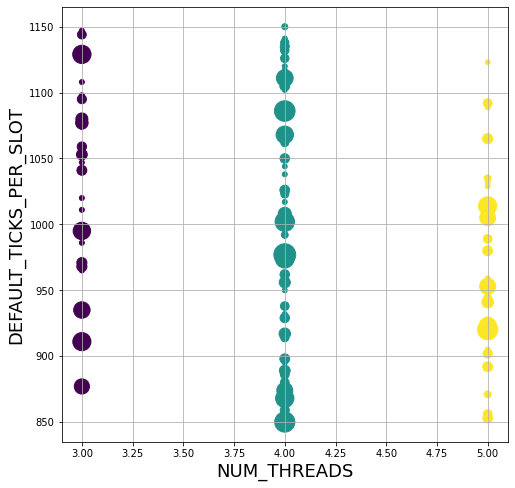

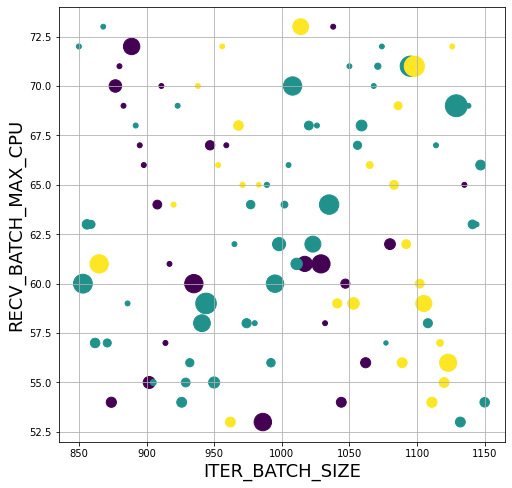

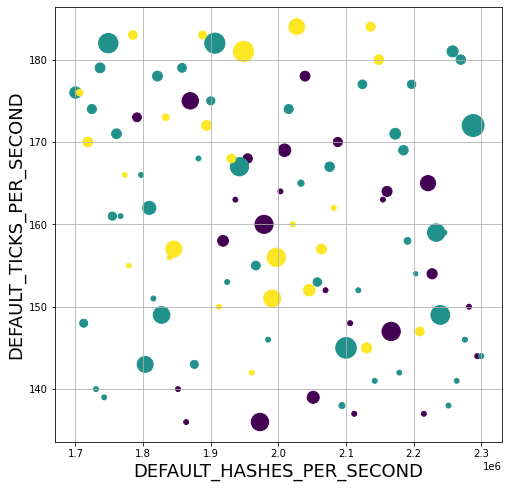

In [364]:
for i in range(3):
    graphique(_X[:, 2*i], _X[:, 2*i+1], column_names[2*i], column_names[2*i+1], _y, _X[:, 0])

### Our new points

In [365]:
data_opt = list()
counter = 0
with open('sur_model2_results.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if counter < 3:     
            counter += 1
        else:
            data_opt.append([float(x) for x in row])
data_opt = np.array(data_opt)

sur_data_opt = data_opt[-num_points:, :]
x_opt = sur_data_opt[:, :6]
y_opt = sur_data_opt[:, 6]

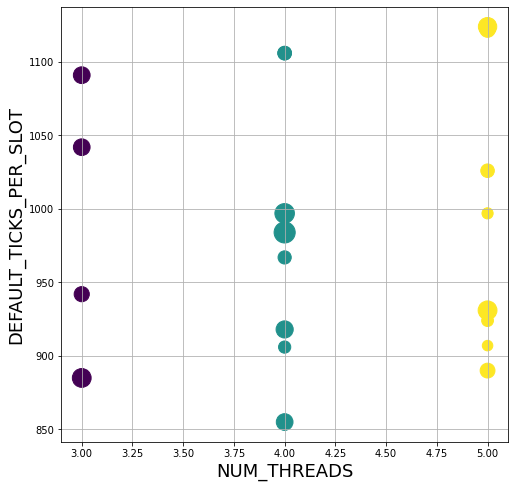

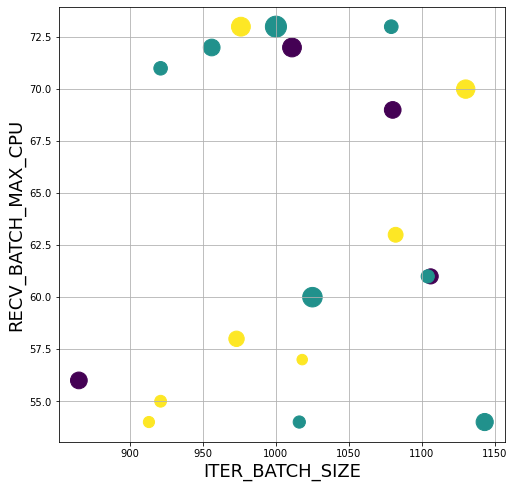

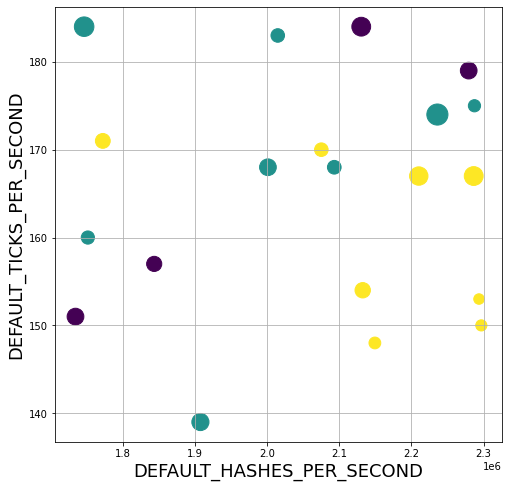

In [366]:
for i in range(3):
    graphique(x_opt[:, 2*i], x_opt[:, 2*i+1], column_names[2*i], column_names[2*i+1], y_opt, x_opt[:, 0])

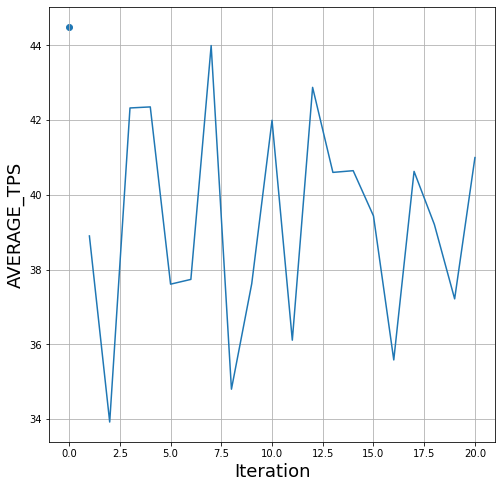

In [367]:
# results visualisation
fig = plt.figure(figsize=(8, 8))

plt.plot(np.arange(1, num_points+1), y_opt, label = "")
plt.scatter(0, _y.max()) #our initial max

plt.xlabel("Iteration", fontsize=18)
plt.ylabel(column_names[6], fontsize=18)
plt.grid(which='both')

For a real surrogate optimisation we need 4 components:

1)**Strategy**: Algorithm for choosing new evaluations after the experimental design has been evaluated.

2)**Experimental design**: Generates an initial set of points for building the initial surrogate model

3)**Surrogate model**: Approximates the underlying objective function. Common choices are RBFs, GPs, MARS, etc. In our case - GB

4)**Optimization problem**: All of the available information about the optimization problem, e.g., dimensionality, variable types, objective function, etc.

We have already had an initial experimental design points (Latin hypercube) and have already trained our initial surrogate model
now we have to choose a strategy for our surrogate optimisation and conduct it.

## Here we are using botorch for quicker results (using GP as the model for surrogate)

In [368]:
#!pip install botorch

In [369]:
#!pip install pykeops

In [370]:
import os
import time
from contextlib import ExitStack

import torch
from torch.quasirandom import SobolEngine

import gpytorch
import gpytorch.settings as gpts
import pykeops
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.test_functions import Hartmann
from botorch.utils.transforms import unnormalize
from gpytorch.constraints import Interval
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import MaternKernel, RFFKernel, ScaleKernel
from gpytorch.kernels.keops import MaternKernel as KMaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.preprocessing import MinMaxScaler

from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [371]:
pykeops.test_torch_bindings()  # Make sure the KeOps bindings are working

pyKeOps with torch bindings is working!


## UCB

In [372]:
#training our model (initial)
scaler = MinMaxScaler()
X = torch.from_numpy(scaler.fit_transform(_X))
Y = torch.from_numpy(_y).unsqueeze(-1)

train_Y = (Y - Y.mean()) / Y.std()

likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
model_local = SingleTaskGP(X, train_Y) #, observation_noise = True) #likelihood=likelihood) #, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model_local.likelihood, model_local)
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [373]:
#constructing an aquisition function
UCB = UpperConfidenceBound(model_local, beta=0.1)

In [387]:
#Optimizing acquisiton function
lb = torch.Tensor([3, 850, 850, 53, 1700000, 136])
rb = torch.Tensor([5, 1150, 1150, 73, 2300000, 184])

bounds = torch.stack([lb, rb])
candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=100,
    )

X_opt_ucb = scaler.inverse_transform(candidate)
Y_opt_ucb = acq_value*Y.std() + Y.mean()
Y_bb_ucb = model_fix.predict(X_opt_ucb)
print(X_opt_ucb)
print(f"Our optimisation result {Y_opt_ucb}")
print(f"Our blackbox result {Y_bb_ucb}") #our blackbox
print(f"Initial max result {Y.max()}")

[[1.28497505e+01 3.25720410e+05 2.65563086e+05 1.15681409e+03
  1.24838172e+12 7.67954541e+03]]
Our optimisation result 32.30331645967748
Our blackbox result [48.07508421]
Initial max result 44.499756


## Expected Improvement

In [375]:
from botorch.acquisition import ExpectedImprovement

EI = ExpectedImprovement(model_local, best_f=0.2)

In [385]:
candidate, acq_value = optimize_acqf(
        EI, bounds=bounds, q=1, num_restarts=5, raw_samples=100,
    )

X_opt_ei = scaler.inverse_transform(candidate)
Y_opt_ei = acq_value*Y.std() + Y.mean()
Y_bb_ei = model_fix.predict(X_opt_ei)
print(X_opt_ei)
print(f"Our optimisation result {Y_opt_ei}")
print(f"Our blackbox result {Y_bb_ei}") #our blackbox
print(f"Initial max result {Y.max()}")

[[9.81210947e+00 2.82663031e+05 2.88630090e+05 1.27936490e+03
  1.31180000e+12 8.38478418e+03]]
Our optimisation result 32.383168239221945
Our blackbox result [48.07508421]
Initial max result 44.499756


## Thompson sampling

we are fixing our model after surrogate optimisation, now we are trying to 

Optimisation of a non-convex function (ex: with multiple local mins)
https://gdmarmerola.github.io/ts-for-bayesian-optim/
https://en.wikipedia.org/wiki/Thompson_sampling#:~:text=Thompson%20sampling%2C%20named%20after%20William,to%20a%20randomly%20drawn%20belief.

Ok. So we learned how a GP works, and how we can draw functions from the posterior distribution it learns. 

**1) Fit the GP to the observations we have**

**2) Draw one sample (a function) from the posterior**

**3) Greedily choose the next point with respect to the sample**

The randomness of Thompson Sampling comes from the posterior sample. After we have it, we can just use its minimum as our next point.

Here we are going to use this:
https://botorch.org/tutorials/thompson_sampling

In [377]:
def generate_batch(
    X,
    Y,
    batch_size,
    n_candidates,
    sampler="cholesky",  # "cholesky", "ciq", "rff"
    use_keops=False,
):
    assert sampler in ("cholesky", "ciq", "rff", "lanczos")
    #assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))

    # NOTE: We probably want to pass in the default priors in SingleTaskGP here later
    kernel_kwargs = {"nu": 2.5, "ard_num_dims": X.shape[-1]}
    if sampler == "rff":
        base_kernel = RFFKernel(**kernel_kwargs, num_samples=1024)
    else:
        base_kernel = (
            KMaternKernel(**kernel_kwargs)
            if use_keops
            else MaternKernel(**kernel_kwargs)
        )
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_X = torch.from_numpy(scaler.fit_transform(X))
    train_Y = (Y - Y.mean()) / Y.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model_local = SingleTaskGP(train_X, train_Y, likelihood=likelihood, covar_module=covar_module)
    mll = ExactMarginalLogLikelihood(model_local.likelihood, model_local)
    fit_gpytorch_mll(mll)

    # Draw samples on a Sobol sequence
    sobol = SobolEngine(X.shape[-1], scramble=True)
    X_cand = sobol.draw(n_candidates).to(dtype=dtype, device=device)

    # Thompson sample
    with ExitStack() as es:
        if sampler == "cholesky":
            es.enter_context(gpts.max_cholesky_size(float("inf")))
        elif sampler == "ciq":
            es.enter_context(gpts.fast_computations(covar_root_decomposition=True))
            es.enter_context(gpts.max_cholesky_size(0))
            es.enter_context(gpts.ciq_samples(True))
            es.enter_context(
                gpts.minres_tolerance(2e-3)
            )  # Controls accuracy and runtime
            es.enter_context(gpts.num_contour_quadrature(15))
        elif sampler == "lanczos":
            es.enter_context(gpts.fast_computations(covar_root_decomposition=True))
            es.enter_context(gpts.max_cholesky_size(0))
            es.enter_context(gpts.ciq_samples(False))
        elif sampler == "rff":
            es.enter_context(gpts.fast_computations(covar_root_decomposition=True))

        thompson_sampling = MaxPosteriorSampling(model=model_local, replacement=True)
        X_next = thompson_sampling(X_cand, num_samples=batch_size)
        
    X_ans_next = torch.from_numpy(scaler.inverse_transform(X_next))
    
    return X_ans_next

In [378]:
def run_optimization(
    sampler, n_candidates, max_evals, batch_size, use_keops=False
):
    X = torch.from_numpy(_X)
    Y = torch.from_numpy(_y).unsqueeze(-1)
    
    print(f"len {len(Y)}, shape {Y.dim()} Best value: {Y.max().item():.2e}")

    while len(X) < max_evals:
        # Create a batch
        start = time.monotonic()
        X_next = generate_batch(
            X=X,
            Y=Y,
            batch_size=min(batch_size, max_evals - len(X)),
            n_candidates=n_candidates,
            sampler=sampler,
            use_keops=use_keops,
        )
        
        end = time.monotonic()
        print(f"Generated batch in {end - start:.1f} seconds")
       
        #here we are using blackbox
        Y_next = torch.tensor(
            [model_fix.predict(x.reshape(1, -1)) for x in X_next], dtype=dtype, device=device
        )
        
        # Append data
        X = torch.cat((X, X_next), dim=0)
        Y = torch.cat((Y, Y_next), dim=0)

        print(f"{len(X)}) Best value: {Y.max().item():.2e}")
    return X, Y

In [379]:
batch_size = 1
max_evals = 100+30

shared_args = {
    "max_evals": max_evals,
    "batch_size": batch_size,
}

In [380]:
USE_KEOPS = True if not SMOKE_TEST else False
N_CAND = 50 if not SMOKE_TEST else 10
N_CAND_CHOL = 50 if not SMOKE_TEST else 10

In [381]:
X_th, Y_th = run_optimization("cholesky", N_CAND, **shared_args)

len 100, shape 2 Best value: 4.45e+01
Generated batch in 0.8 seconds
101) Best value: 4.45e+01
Generated batch in 0.8 seconds
102) Best value: 4.45e+01
Generated batch in 0.7 seconds
103) Best value: 4.45e+01
Generated batch in 0.7 seconds
104) Best value: 4.45e+01
Generated batch in 0.7 seconds
105) Best value: 4.45e+01
Generated batch in 0.7 seconds
106) Best value: 4.45e+01
Generated batch in 0.8 seconds
107) Best value: 4.45e+01
Generated batch in 0.6 seconds
108) Best value: 4.45e+01
Generated batch in 0.8 seconds
109) Best value: 4.45e+01
Generated batch in 1.3 seconds
110) Best value: 4.45e+01
Generated batch in 0.7 seconds
111) Best value: 4.45e+01
Generated batch in 0.7 seconds
112) Best value: 4.45e+01
Generated batch in 0.8 seconds
113) Best value: 4.45e+01
Generated batch in 0.8 seconds
114) Best value: 4.45e+01
Generated batch in 0.6 seconds
115) Best value: 4.45e+01
Generated batch in 0.7 seconds
116) Best value: 4.45e+01
Generated batch in 0.8 seconds
117) Best value: 4.

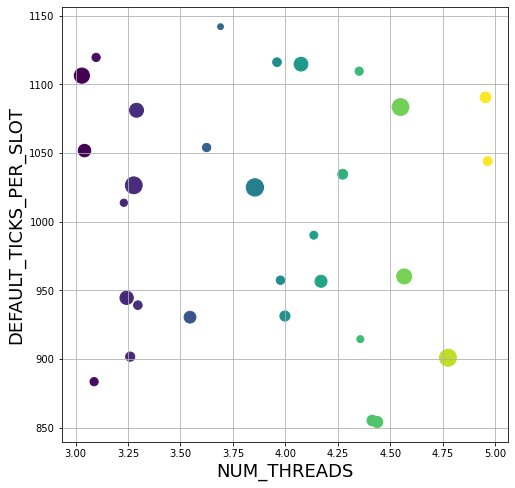

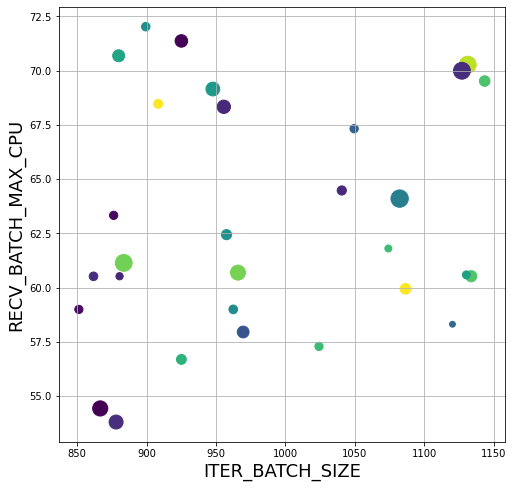

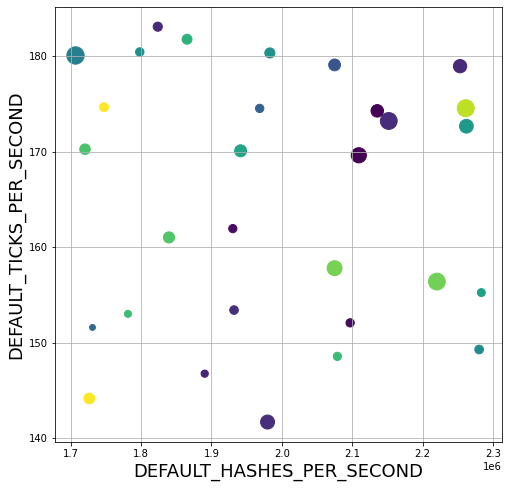

In [382]:
for i in range(3):
    graphique(X_th[100:, 2*i], X_th[100:, 2*i+1], column_names[2*i], column_names[2*i+1], Y_th[100:], X_th[100:, 0])

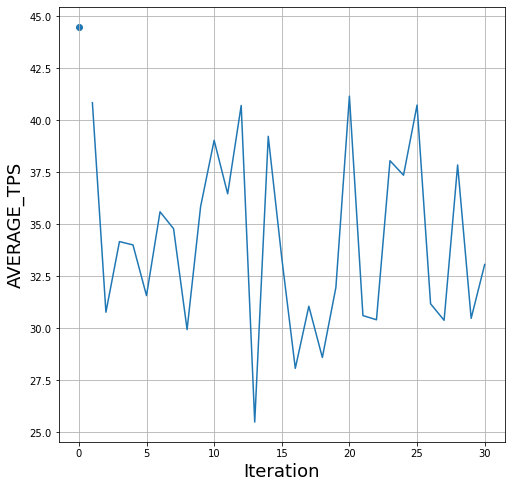

In [383]:
#Thompson sampling results
fig = plt.figure(figsize=(8, 8))

plt.plot(np.arange(1, max_evals - 100+1), Y_th[100:], label = "")
plt.scatter(0, Y_th.max()) #our initial max

plt.xlabel("Iteration", fontsize=18)
plt.ylabel(column_names[6], fontsize=18)
plt.grid(which='both')

## Our results

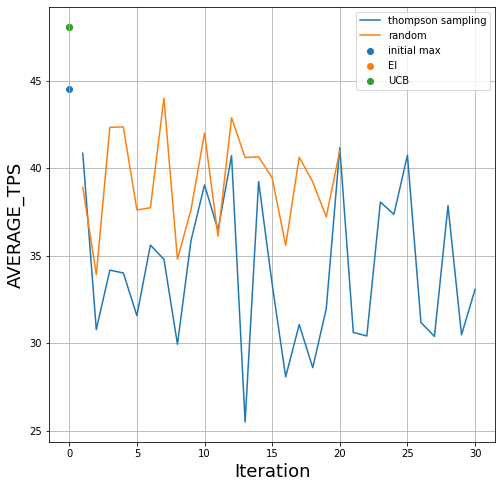

In [388]:
fig = plt.figure(figsize=(8, 8))

plt.plot(np.arange(1, max_evals - 100+1), Y_th[100:], label = "thompson sampling")
plt.plot(np.arange(1, num_points+1), y_opt, label = "random")

plt.scatter(0, _y.max(), label="initial max") #our initial max
plt.scatter(0, Y_bb_ei, label="EI") #blackbox result on ei
plt.scatter(0, Y_bb_ucb, label="UCB") #blackboxresult on ucb

plt.xlabel("Iteration", fontsize=18)
plt.ylabel(column_names[6], fontsize=18)
plt.grid(which='both')
plt.legend()

Возможное объяснение таких результатов в том, что мы используем гаусовские модели внутри самой суррогатной оптимизации, хотя мы уже показывали, что градиентный буст работает лучше(в данный момент именно он используется в качестве artificial blackbox для random и для thompson sampling, а для остальных только на финальных ответах, возможно в этом и кроется проблема), но я не уверен.

С batch-size в thompson sampling поигрался, результаты выдает схожие, смысла увеличивать его не вижу.